<a href="https://colab.research.google.com/github/EliSchwartz/synthetic-watch-faces-dataset/blob/main/gen_synthetic_watch_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import random
import math
import argparse
from datetime import datetime
from matplotlib.transforms import Affine2D
import cv2
import io
from PIL import Image
from typing import List, Dict, Tuple
import os
from tqdm import tqdm
import pandas as pd
from datasets import Dataset, Features, Image as HFImage, Value


In [ ]:
def random_color(min_brightness=0.0, max_brightness=1.0, contrast_with=None, min_contrast=0.4):
    """
    Generate a random color with a minimum brightness and optionally ensure
    contrast with another color.

    Args:
        min_brightness (float): Minimum brightness value (0-1)
        contrast_with (tuple): Optional (r,g,b) color to ensure contrast against
        min_contrast (float): Minimum contrast difference if contrast_with is provided

    Returns:
        tuple: (r,g,b) color values between 0-1
    """
    while True:
        r, g, b = [random.random() for _ in range(3)]
        brightness = (r + g + b) / 3

        # Check minimum brightness
        if brightness < min_brightness or brightness > max_brightness:
            continue

        # If we need to ensure contrast
        if contrast_with is not None:
            # Calculate contrast using luminance difference
            # This is a simplified version of contrast calculation
            cr, cg, cb = contrast_with
            c_brightness = (cr + cg + cb) / 3

            # Calculate color difference
            color_diff = abs(brightness - c_brightness)

            # Calculate color component differences for more accurate contrast
            r_diff = abs(r - cr)
            g_diff = abs(g - cg)
            b_diff = abs(b - cb)
            component_diff = (r_diff + g_diff + b_diff) / 3

            # If contrast is insufficient, try again
            if color_diff < min_contrast / 2 or component_diff < min_contrast:
                continue

        # If we got here, the color meets all criteria
        return (r, g, b)


def center_crop(img, new_width, new_height):
    # Get current dimensions
    width, height = img.size

    # Calculate coordinates for center crop
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = left + new_width
    bottom = top + new_height

    # Crop the center of the image
    return img.crop((left, top, right, bottom))

In [ ]:
def generate_random_watch_face(hhmm, output_file=None, apply_wrap=False, size=256, maintain_proportions=True):
    """Generate a random analog watch face showing the specified time,
    with random perspective projections using cv2.warpPerspective.

    Parameters:
    -----------
    hours : int
        Hour to display (0-23)
    minutes : int
        Minute to display (0-59)
    output_file : str, optional
        Path to save the generated image
    apply_wrap : bool, optional
        Whether to apply perspective warping
    size : int, optional
        Size of the output image in pixels (default: 256)
    maintain_proportions : bool, optional
        Whether to maintain the original proportions of elements (default: True)

    Returns:
    --------
    PIL.Image: The generated watch face image
    """

    if isinstance(hhmm, str):
      hours, minutes = hhmm.split(':')
    else:
      hours, minutes = hhmm
    hours, minutes = int(hours)%12, int(minutes)%60
    # Calculate figure size and DPI to get desired output size
    # For a square image of size x size pixels, we need:
    # figsize * dpi = size
    # We can set figsize=1 and dpi=size
    fig, ax = plt.subplots(figsize=(1, 1), dpi=size, frameon=False)
    ax.set_aspect('equal')
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.axis('off')

    # Random parameters
    watch_face_color = random_color(min_brightness=0.6)
    border_color = random_color(min_brightness=0.2)
    hour_hand_color = random_color(contrast_with=watch_face_color)
    minute_hand_color = random_color(contrast_with=watch_face_color)
    dial_color = random_color(contrast_with=watch_face_color, min_contrast=0.4)


    # Calculate scaling factor to maintain proportions
    if maintain_proportions:
        font_scale = 4
    else:
        font_scale = 1

    # Determine watch face shape (circle, rounded square, ellipse, polygon)
    shape_type = random.choice(['rounded_square', 'ellipse', 'polygon'])

    if shape_type == 'circle':
        # Draw circular watch face
        face_radius = 1.0
        face = plt.Circle((0, 0), face_radius, fill=True, color=watch_face_color)
        border = plt.Circle((0, 0), face_radius, fill=False, color=border_color, linewidth=random.uniform(1, 4)/font_scale)
        ax.add_patch(face)
        ax.add_patch(border)

    elif shape_type == 'rounded_square':
        # Draw rounded square watch face
        side_length = 1.8
        corner_radius = random.uniform(0.2, 0.5)
        rounded_rect = patches.FancyBboxPatch(
            (-side_length/2, -side_length/2),
            side_length,
            side_length,
            boxstyle=f"round,pad=0,rounding_size={corner_radius}",
            color=watch_face_color
        )
        ax.add_patch(rounded_rect)
        rounded_rect_border = patches.FancyBboxPatch(
            (-side_length/2, -side_length/2),
            side_length,
            side_length,
            boxstyle=f"round,pad=0,rounding_size={corner_radius}",
            fill=False,
            color=border_color,
            linewidth=random.uniform(1, 4)/font_scale
        )
        ax.add_patch(rounded_rect_border)

    elif shape_type == 'ellipse':
        # Draw elliptical watch face
        width = random.uniform(1.7, 2.0)
        height = random.uniform(1.7, 2.0)
        face = patches.Ellipse((0, 0), width, height, fill=True, color=watch_face_color)
        border = patches.Ellipse((0, 0), width, height, fill=False, color=border_color, linewidth=random.uniform(1, 4)/font_scale)
        ax.add_patch(face)
        ax.add_patch(border)

    elif shape_type == 'polygon':
        # Draw polygonal watch face
        num_sides = random.choice([6,8,10])
        radius = 1.0
        angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)
        vertices = [(radius * np.cos(angle), radius * np.sin(angle)) for angle in angles]

        face = patches.Polygon(vertices, closed=True, fill=True, color=watch_face_color)
        border = patches.Polygon(vertices, closed=True, fill=False, color=border_color, linewidth=random.uniform(1, 4)/font_scale)
        ax.add_patch(face)
        ax.add_patch(border)

    # Roman numeral mapping
    roman_numerals = {
        1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V', 6: 'VI',
        7: 'VII', 8: 'VIII', 9: 'IX', 10: 'X', 11: 'XI', 12: 'XII'
    }

    # Font settings with proper scaling
    font_weight = random.choice(['normal', 'bold'])
    font_size = random.uniform(0.1, 0.13)

    # Positioning distances
    number_distance = random.uniform(0.75, 0.8)  # Numbers positioned slightly inside
    marker_distance = random.uniform(0.8, 0.85)  # Markers slightly outside

    # For dash markers, set consistent inner and outer radius
    dash_inner = marker_distance - 0.1
    dash_outer = marker_distance
    dash_thickness = random.uniform(0.01, 0.02)

    # Define possible marker types
    marker_types = ['circle', 'dash', 'triangle']

    # STEP 1: Choose the 12 indicator (position 0)
    twelve_style = random.choice(['number', 'roman', 'marker'])
    twelve_marker_type = None

    # Render the 12 indicator
    angle = math.radians(90)  # 12 o'clock position (top)
    x = number_distance * math.cos(angle)
    y = number_distance * math.sin(angle)

    if twelve_style == 'number':
        plt.text(x, y, "12",
                fontsize=font_size * 100 / font_scale,
                color=dial_color,
                fontweight=font_weight,
                ha='center', va='center')
    elif twelve_style == 'roman':
        plt.text(x, y, "XII",
                fontsize=font_size * 100 / font_scale,
                color=dial_color,
                fontweight=font_weight,
                ha='center', va='center')
    else:  # marker
        twelve_marker_type = random.choice(marker_types)
        if twelve_marker_type == 'circle':
            size = random.uniform(0.04, 0.07)
            marker = patches.Circle((x, y), size, fill=True, color=dial_color)
            ax.add_patch(marker)
        elif twelve_marker_type == 'dash':
            x1 = dash_inner * math.cos(angle)
            y1 = dash_inner * math.sin(angle)
            x2 = dash_outer * math.cos(angle)
            y2 = dash_outer * math.sin(angle)
            plt.plot([x1, x2], [y1, y2], color=dial_color, linewidth=dash_thickness*100*1.5/font_scale)
        elif twelve_marker_type == 'triangle':
            triangle_size = random.uniform(0.06, 0.1)
            triangle_points = [
                (x, y + triangle_size/2),
                (x - triangle_size/2, y - triangle_size/2),
                (x + triangle_size/2, y - triangle_size/2)
            ]
            triangle = patches.Polygon(triangle_points, closed=True, fill=True, color=dial_color)
            ax.add_patch(triangle)

    # STEP 2: Choose the quarter indicators (3, 6, 9)
    quarters_style = random.choice(['number', 'roman', 'marker', 'none'])
    quarters_marker_type = None

    # If quarters_style is a marker and it's the same as the 12 marker, change to none
    if quarters_style == 'marker' and twelve_style == 'marker':
        quarters_marker_type = random.choice([m for m in marker_types if m != twelve_marker_type])
        if not quarters_marker_type:  # Fallback if no other marker types available
            quarters_style = 'none'
    elif quarters_style == 'marker':
        quarters_marker_type = random.choice(marker_types)

    # Render the quarter indicators (3, 6, 9)
    quarter_positions = [3, 6, 9]
    for pos in quarter_positions:
        angle = math.radians(90 - (30 * pos))

        x = number_distance * math.cos(angle)
        y = number_distance * math.sin(angle)

        if quarters_style == 'number':
            plt.text(x, y, str(pos),
                    fontsize=font_size * 100 / font_scale,
                    color=dial_color,
                    fontweight=font_weight,
                    ha='center', va='center')
        elif quarters_style == 'roman':
            plt.text(x, y, roman_numerals[pos],
                    fontsize=font_size * 100 / font_scale,
                    color=dial_color,
                    fontweight=font_weight,
                    ha='center', va='center')
        elif quarters_style == 'marker' and quarters_marker_type:
            if quarters_marker_type == 'circle':
                size = random.uniform(0.04, 0.06)
                marker = patches.Circle((x, y), size, fill=True, color=dial_color)
                ax.add_patch(marker)
            elif quarters_marker_type == 'dash':
                x1 = dash_inner * math.cos(angle)
                y1 = dash_inner * math.sin(angle)
                x2 = dash_outer * math.cos(angle)
                y2 = dash_outer * math.sin(angle)
                plt.plot([x1, x2], [y1, y2], color=dial_color, linewidth=dash_thickness*100*1.2/font_scale)
            elif quarters_marker_type == 'triangle':
                triangle_size = random.uniform(0.05, 0.08)
                # Rotate triangle to point outward
                triangle_points = [
                    (x + triangle_size/2 * math.cos(angle), y + triangle_size/2 * math.sin(angle)),
                    (x + triangle_size/2 * math.cos(angle + math.pi*2/3), y + triangle_size/2 * math.sin(angle + math.pi*2/3)),
                    (x + triangle_size/2 * math.cos(angle + math.pi*4/3), y + triangle_size/2 * math.sin(angle + math.pi*4/3))
                ]
                triangle = patches.Polygon(triangle_points, closed=True, fill=True, color=dial_color)
                ax.add_patch(triangle)

    # STEP 3: Choose the other hour indicators (1, 2, 4, 5, 7, 8, 10, 11)
    if quarters_style == 'none':
      other_hours_style = 'none'
    else:
      other_hours_style = random.choice(['number', 'roman', 'marker', 'none'])
    other_hours_marker_type = None

    # If other_hours_style is a marker and it's the same as the 12 marker, change to none
    if other_hours_style == 'marker' and twelve_style == 'marker':
        other_hours_marker_type = random.choice([m for m in marker_types if m != twelve_marker_type])
        if not other_hours_marker_type:  # Fallback if no other marker types available
            other_hours_style = 'none'
    elif other_hours_style == 'marker':
        other_hours_marker_type = random.choice(marker_types)

    # Render the other hour indicators
    other_positions = [1, 2, 4, 5, 7, 8, 10, 11]
    for pos in other_positions:
        angle = math.radians(90 - (30 * pos))

        x = number_distance * math.cos(angle)
        y = number_distance * math.sin(angle)

        if other_hours_style == 'number':
            plt.text(x, y, str(pos),
                    fontsize=font_size * 100 / font_scale,
                    color=dial_color,
                    fontweight=font_weight,
                    ha='center', va='center')
        elif other_hours_style == 'roman':
            plt.text(x, y, roman_numerals[pos],
                    fontsize=font_size * 100 / font_scale,
                    color=dial_color,
                    fontweight=font_weight,
                    ha='center', va='center')
        elif other_hours_style == 'marker' and other_hours_marker_type:
            if other_hours_marker_type == 'circle':
                size = random.uniform(0.02, 0.04)
                marker = patches.Circle((x, y), size, fill=True, color=dial_color)
                ax.add_patch(marker)
            elif other_hours_marker_type == 'dash':
                x1 = dash_inner * math.cos(angle)
                y1 = dash_inner * math.sin(angle)
                x2 = dash_outer * math.cos(angle)
                y2 = dash_outer * math.sin(angle)
                plt.plot([x1, x2], [y1, y2], color=dial_color, linewidth=dash_thickness*100/font_scale)
            elif other_hours_marker_type == 'triangle':
                triangle_size = random.uniform(0.03, 0.06)
                # Rotate triangle to point outward
                triangle_points = [
                    (x + triangle_size/2 * math.cos(angle), y + triangle_size/2 * math.sin(angle)),
                    (x + triangle_size/2 * math.cos(angle + math.pi*2/3), y + triangle_size/2 * math.sin(angle + math.pi*2/3)),
                    (x + triangle_size/2 * math.cos(angle + math.pi*4/3), y + triangle_size/2 * math.sin(angle + math.pi*4/3))
                ]
                triangle = patches.Polygon(triangle_points, closed=True, fill=True, color=dial_color)
                ax.add_patch(triangle)

    # Render sub hour indicators
    if False:
      add_minute = random.choice([True, False, False]) and other_hours_style!='none'
      if add_minute:
        other_positions = list(set(np.arange(0, 12, 12/(12*5))) - set(np.arange(0, 12)))
        for pos in other_positions:
            angle = math.radians(90 - (30 * pos))

            x = number_distance * math.cos(angle)
            y = number_distance * math.sin(angle)
            x1 = (dash_inner+0.05) * math.cos(angle)
            y1 = (dash_inner+0.05) * math.sin(angle)
            x2 = dash_outer * math.cos(angle)
            y2 = dash_outer * math.sin(angle)
            plt.plot([x1, x2], [y1, y2], color=dial_color, linewidth=dash_thickness*100/font_scale)

    # Calculate hand angles
    # Correct angle calculation (90 degrees is at 12 o'clock)
    if False:
      minutes += random.uniform(0, 0.9) # can be up to one minute more, we keep it a bit smaller
    hour_angle = math.radians(90 - ((hours % 12) * 30 + minutes * 0.5))
    minute_angle = math.radians(90 - (minutes * 6))


    # Draw minute hand
    minute_hand_length = random.uniform(0.6, 0.8)
    minute_hand_width = random.uniform(0.01, 0.03)
    minute_hand_endpts = [
        (0, 0),
        (minute_hand_length * math.cos(minute_angle),
         minute_hand_length * math.sin(minute_angle))
    ]

    # Add slight thickness variations to the minute hand
    ax.plot(
        [p[0] for p in minute_hand_endpts],
        [p[1] for p in minute_hand_endpts],
        color=minute_hand_color,
        linewidth=minute_hand_width*100/font_scale
    )

    # Draw hour hand (shorter and thicker)
    hour_hand_length = random.uniform(0.4, 0.5)
    hour_hand_width = random.uniform(0.02, 0.04)
    hour_hand_endpts = [
        (0, 0),
        (hour_hand_length * math.cos(hour_angle),
         hour_hand_length * math.sin(hour_angle))
    ]

    ax.plot(
        [p[0] for p in hour_hand_endpts],
        [p[1] for p in hour_hand_endpts],
        color=hour_hand_color,
        linewidth=hour_hand_width*100/font_scale
    )

    # Draw the center pin
    center_pin_radius = random.uniform(0.03, 0.06)
    center_pin = plt.Circle((0, 0), center_pin_radius, fill=True, color=random_color())
    ax.add_patch(center_pin)

    # Render the figure to an image
    fig.canvas.draw()
    img_pil = Image.frombytes('RGBA', fig.canvas.get_width_height(),
                         fig.canvas.tostring_argb(), 'raw', 'ARGB', 0, 1)
    plt.close(fig)

    # Apply rotation
    rotation_angle = 5*np.random.randn()
    # PIL's rotate keeps full image by default, expand=True ensures the whole rotated image fits
    img_pil = img_pil.rotate(rotation_angle, resample=Image.BICUBIC, expand=False)
    # img_pil = center_crop(img_pil, size, size)


    # Save or show the image
    if output_file:
        img_pil.save(output_file)
        print(f"Watch face saved to {output_file}")

    return img_pil

0.1sec per sample


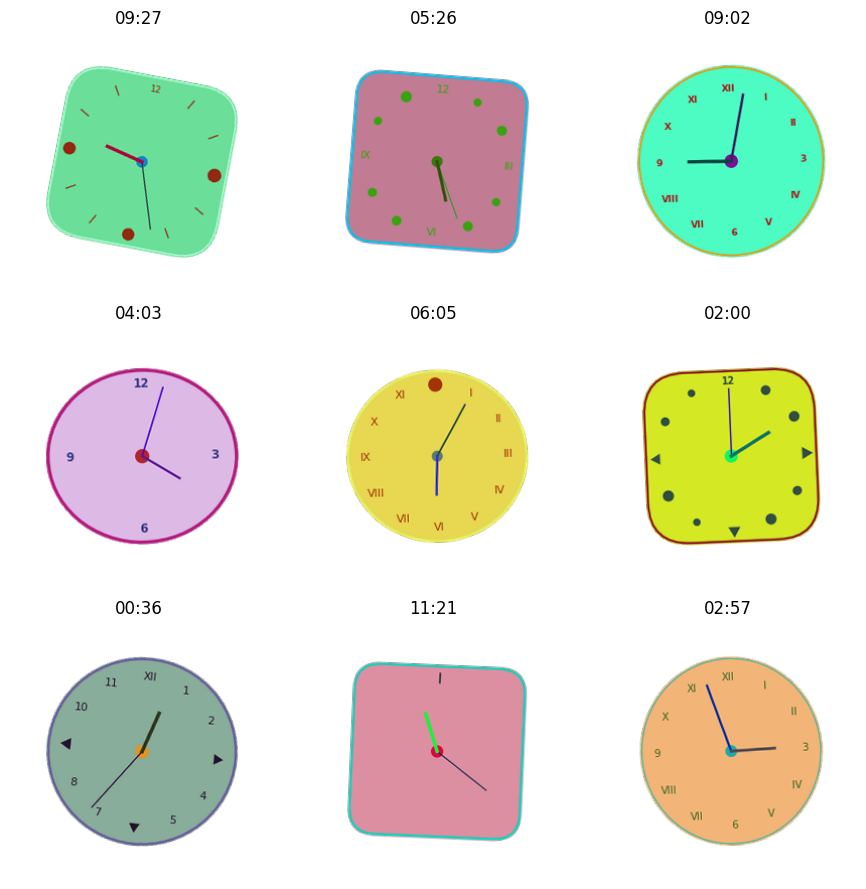

In [ ]:
# h, m = parse_time('17:37')
import time
# Create a figure with a 3x3 grid
plt.figure(figsize=(9, 9))
s = time.time()
# Generate 9 watch faces with slightly different times
for i in range(3):
    for j in range(3):
        # Create subplot
        plt.subplot(3, 3, i * 3 + j + 1)
        h = random.randint(0,11)
        m = random.randint(0,59)
        # Generate and display watch face
        img = generate_random_watch_face((h, m))
        plt.imshow(img)
        plt.title(f'{h:02d}:{m:02d}')
        plt.axis('off')
print(f'{(time.time()-s)/9:.02}sec per sample')
# Adjust layout and display
plt.tight_layout()
plt.show()

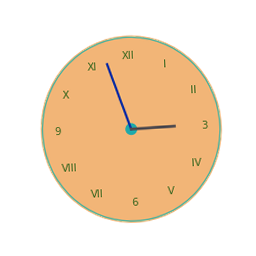

In [ ]:
img

In [ ]:
def get_all_possible_times():
    """Generate all possible times in format (hour, minute) where hour=1..12, minute=0..59."""
    all_times = []
    for hour in range(1, 13):
        for minute in range(60):
            all_times.append((hour, minute))
    return all_times

def format_time_string(hour: int, minute: int) -> str:
    """Format time as 'hh:mm'."""
    return f"{hour:02d}:{minute:02d}"

def split_times_for_dataset(random_seed: int = 42) -> Dict[str, List[Tuple[int, int]]]:
    """
    Split all possible times into main and novel sets (90% and 10%).

    Returns:
        Dictionary with keys 'main_times', 'novel_times'.
    """

    all_times = get_all_possible_times()
    total_times = len(all_times)  # 12 * 60 = 720 possible times

    # Randomly select 10% of times for novel testing
    novel_times_count = int(total_times * 0.1)
    novel_indices = set(random.sample(range(total_times), novel_times_count))

    novel_times = [all_times[i] for i in range(total_times) if i in novel_indices]
    main_times = [all_times[i] for i in range(total_times) if i not in novel_indices]

    return {
        'main_times': main_times,
        'novel_times': novel_times
    }

def sample_times_with_replacement(times, count: int, random_seed: int = None):
    """Sample times with replacement to achieve desired count."""
    if random_seed is not None:
        random.seed(random_seed)

    # If count is greater than available times, we'll need to sample with replacement
    if count <= len(times):
        return random.sample(times, count)
    else:
        # Sample with replacement
        return [random.choice(times) for _ in range(count)]

def generate_dataset(time_splits, token, repo_id, output_dir: str = "./watch_faces_data"):
    """
    Generate images for all time splits and prepare Hugging Face datasets.
    Each split will sample from its respective time pool with replacement to reach desired counts.

    Args:
        time_splits: Dictionary with 'main_times' and 'novel_times'
        output_dir: Directory to save temporary images
    """
    os.makedirs(output_dir, exist_ok=True)

    # Define desired sizes for each split
    split_sizes = {
        'train': 8000,
        'val': 1000,
        'test': 1000,
        'test_novel': 1000
    }

    main_times = time_splits['main_times']
    novel_times = time_splits['novel_times']

    datasets = {}

    # Create each split
    for split_name, size in split_sizes.items():
        print(f"Generating {size} images for {split_name} split...")

        # Create directories for images
        split_dir = os.path.join(output_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)

        # Sample times with replacement
        if split_name == 'test_novel':
            times_to_use = sample_times_with_replacement(novel_times, size, random_seed=split_name.__hash__())
        else:
            times_to_use = sample_times_with_replacement(main_times, size, random_seed=split_name.__hash__())

        # Generate data
        data = []
        for i, (hour, minute) in enumerate(tqdm(times_to_use)):
            # Generate image using the provided function
            # Each call will generate a different random appearance
            img = generate_random_watch_face((hour, minute))

            # Create filename and save path
            time_str = format_time_string(hour, minute)
            filename = f"{time_str.replace(':', '_')}_{i}.png"  # Add index to make filenames unique
            save_path = os.path.join(split_dir, filename)

            # Save image
            img.save(save_path)

            # Add to dataset
            data.append({
                "image": save_path,
                "text": time_str
            })

        # Create dataset
        df = pd.DataFrame(data)
        dataset = Dataset.from_pandas(df)

        # Convert to HF format with correct image handling
        dataset = dataset.cast_column("image", HFImage())

        # Push to the Hugging Face Hub
        dataset.push_to_hub(
            repo_id,
            split=split_name,
            token=token,
            private=False,  # Set to True if you want a private dataset
        )
        print(f'Uploaded {split_name}')

        # datasets[split_name] = dataset

    # return datasets

def upload_to_huggingface(datasets, repo_id: str, token: str = None):
    """
    Upload all splits to Hugging Face.

    Args:
        datasets: Dictionary of datasets
        repo_id: Hugging Face repository ID (e.g., 'username/dataset-name')
        token: Hugging Face API token
    """
    from datasets import DatasetDict

    # Create a DatasetDict
    dataset_dict = DatasetDict(datasets)

    # Push to the Hugging Face Hub
    dataset_dict.push_to_hub(
        repo_id,
        token=token,
        private=False,  # Set to True if you want a private dataset
    )

    print(f"Datasets uploaded to {repo_id}")

In [ ]:
# Split times
import random
random.seed(0)
np.random.seed(0)

print("Splitting times...")
splits = split_times_for_dataset()

# Check counts to ensure they match requirements
for split_name, times in splits.items():
    print(f"{split_name}: {len(times)} samples")

# Modify with your actual repository ID and token
repo_id = "elischwartz/synthetic-watch-faces-dataset"
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')  # Make sure this matches your secret name
# Set the token as an environment variable
os.environ["HUGGINGFACE_TOKEN"] = hf_token

# Generate datasets
print("Generating datasets...")
generate_dataset(splits, hf_token, repo_id)



# # Upload to Hugging Face
# print("Uploading to Hugging Face...")
# upload_to_huggingface(datasets, repo_id, hf_token)

print("Done!")

Splitting times...
main_times: 648 samples
novel_times: 72 samples
Generating datasets...
Generating 8000 images for train split...


100%|██████████| 8000/8000 [07:36<00:00, 17.51it/s]


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/80 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/639 [00:00<?, ?B/s]

Uploaded train
Generating 1000 images for val split...


100%|██████████| 1000/1000 [00:52<00:00, 19.14it/s]


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/638 [00:00<?, ?B/s]

Uploaded val
Generating 1000 images for test split...


100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/638 [00:00<?, ?B/s]

Uploaded test
Generating 1000 images for test_novel split...


100%|██████████| 1000/1000 [00:51<00:00, 19.43it/s]


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/638 [00:00<?, ?B/s]

Uploaded test_novel
Done!
